## Stochastic Variational Inference in the TrueSkill Model

In [25]:
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd
import math


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Part 1 Recap:

### Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

#### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

#### The likelihood:
For each observed game, the probability that player $A$ beats player $B$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent, given the players' skills.
We use $M$ to denote the number of games.

Let's recal some useful functions too:
**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.
**b)** The function `logp_a_beats_b`, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [2]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [5]:

def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):

    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
        plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
        plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy. The original Trueskill paper from 2007 used message passing.

We will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.

At first let's implement functions to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

In [6]:
def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[0])

def diag_gaussian_logpdf(x, mean, log_std):
    std = torch.exp(log_std)
    D = mean.shape[0]
    density = -0.5 * D * math.log(2 * math.pi) - torch.sum(log_std) - 0.5 * torch.sum(((x - mean) / std) ** 2, dim=1)
    return density

def batch_elbo(logprob, mean, log_std, num_samples):
    samples = diag_gaussian_samples(mean, log_std, num_samples)
    return torch.mean(logprob(samples) - diag_gaussian_logpdf(samples, mean, log_std))

Now let's write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

In [8]:
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
    return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  
    mean, log_std = params
    return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, mean, log_std, num_samples_per_iter)

Now we can initialize a set of variational parameters and optimize them to approximate the joint distribution where we observe player A winning 10 games. Let's also plto the target distribution 

  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

Optimizing variational parameters...


 10%|███████▌                                                                        | 76/800 [00:00<00:02, 304.61it/s]

Iteration 0 lower bound 8.885974884033203
Iteration 25 lower bound 9.521559715270996
Iteration 50 lower bound 7.517348766326904
Iteration 75 lower bound 5.967678070068359
Iteration 100 lower bound 4.579402446746826
Iteration 125 lower bound 4.903922080993652
Iteration 150 lower bound 5.1009416580200195


 38%|██████████████████████████████▍                                                | 308/800 [00:00<00:00, 644.40it/s]

Iteration 175 lower bound 4.053757667541504
Iteration 200 lower bound 3.9735584259033203
Iteration 225 lower bound 3.868100643157959
Iteration 250 lower bound 3.336135149002075
Iteration 275 lower bound 3.5659825801849365
Iteration 300 lower bound 3.035407066345215
Iteration 325 lower bound 3.0310919284820557
Iteration 350 lower bound 3.310670852661133


 56%|████████████████████████████████████████████▍                                  | 450/800 [00:00<00:00, 639.50it/s]

Iteration 375 lower bound 3.020430326461792
Iteration 400 lower bound 3.116424560546875
Iteration 425 lower bound 2.9525063037872314
Iteration 450 lower bound 3.005530595779419
Iteration 475 lower bound 3.079376220703125
Iteration 500 lower bound 3.032322883605957


 82%|█████████████████████████████████████████████████████████████████▏             | 660/800 [00:01<00:00, 656.14it/s]

Iteration 525 lower bound 2.9509754180908203
Iteration 550 lower bound 2.7846250534057617
Iteration 575 lower bound 2.912384033203125
Iteration 600 lower bound 2.9499447345733643
Iteration 625 lower bound 2.942617416381836
Iteration 650 lower bound 2.9133636951446533


 91%|███████████████████████████████████████████████████████████████████████▊       | 727/800 [00:01<00:00, 567.94it/s]

Iteration 675 lower bound 2.9101855754852295
Iteration 700 lower bound 2.9294469356536865
Iteration 725 lower bound 2.9088234901428223
Iteration 750 lower bound 2.977482318878174
Iteration 775 lower bound 3.138885498046875


100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 549.94it/s]


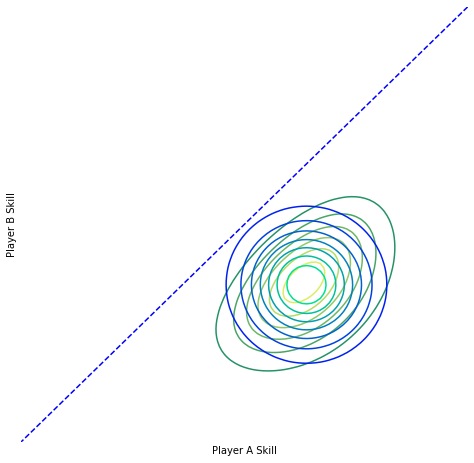

<Figure size 432x288 with 0 Axes>

In [9]:
def callback(params, t):
    if t % 25 == 0:
        print("Iteration {} lower bound {}".format(t, objective(params)))


D = 2
init_log_std  = torch.tensor([0.0, 0.0], requires_grad=True) # TODO.
init_mean = torch.tensor([0.0, 0.0], requires_grad=True)# TODO

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()


print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    zs = torch.stack([z1.flatten(), z2.flatten()], dim=1)
    probs = torch.exp(diag_gaussian_logpdf(zs, mean, logstd))
    return probs.view(z1.shape)

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill", f2=approx_posterior_2d)

Simillary, we can write a loss function called $\texttt{objective}$  that takes the variational distribution parameters, and returns a negative ELBO estimate using simple Monte Carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint distribution where we observe player A winning 10 games and player B winning 10 games.


In [10]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    z1, z2 = z1z2[:, 0], z1z2[:, 1]
    return log_posterior_beat_each_other_10_times(z1, z2)

def objective(params):
    mean, log_std = params[0], params[1]
    samples = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
    probs = log_posterior_beat_each_other_10_times_1_arg(samples)
    return -torch.mean(probs)


Let's optimize the parameters, and report the final loss as well as plot the optimized variational approximation contours and the target distribution on the same axes.

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 752.26it/s]

Optimizing variational parameters...
Iteration 0 lower bound 20.006959915161133
Iteration 25 lower bound 20.087932586669922
Iteration 50 lower bound 18.575111389160156
Iteration 75 lower bound 18.622404098510742


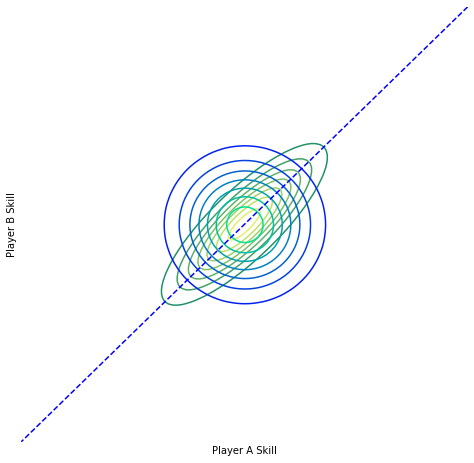

<Figure size 432x288 with 0 Axes>

In [11]:
init_mean = torch.tensor([0.0, 0.0], requires_grad=True)
init_log_std = torch.tensor([0.0, 0.0], requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

### Approximate inference conditioned on real data

The dataset contains data on 2546 chess games amongst 1434 players:
 - 'names' is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - 'games' is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column of 'games' contains the indices of the players who won.
The second column of 'games' contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess

In [13]:
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')

games = torch.LongTensor(games)

100% [..............................................................................] 20722 / 20722

Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ below takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills. 

In [15]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the datase as well as the objective function.

In [16]:
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

Now let's optimize and report the final loss

In [17]:
def callback(params, t):
    if t % 25 == 0:
        print("Iteration {} lower bound {}".format(t, objective(params)))# Set up optimizer.

init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss

for t in trange(0, n_iters):
    update()
    callback(params, t)

print(f"Final loss: {objective(params).item()}\n")

  1%|█▏                                                                                | 7/500 [00:00<00:14, 33.54it/s]

Iteration 0 lower bound 2291.8408203125


  6%|████▋                                                                            | 29/500 [00:00<00:16, 27.89it/s]

Iteration 25 lower bound 2186.3017578125


 11%|████████▋                                                                        | 54/500 [00:01<00:14, 31.74it/s]

Iteration 50 lower bound 2081.920654296875


 16%|█████████████                                                                    | 81/500 [00:02<00:14, 28.01it/s]

Iteration 75 lower bound 2001.042236328125


 21%|████████████████▊                                                               | 105/500 [00:03<00:13, 30.09it/s]

Iteration 100 lower bound 1936.94775390625


 26%|█████████████████████                                                           | 132/500 [00:04<00:11, 32.93it/s]

Iteration 125 lower bound 1876.08544921875


 31%|████████████████████████▉                                                       | 156/500 [00:04<00:09, 34.86it/s]

Iteration 150 lower bound 1836.3558349609375


 36%|████████████████████████████▊                                                   | 180/500 [00:05<00:09, 33.92it/s]

Iteration 175 lower bound 1803.2603759765625


 41%|████████████████████████████████▋                                               | 204/500 [00:06<00:08, 34.72it/s]

Iteration 200 lower bound 1774.2879638671875


 46%|█████████████████████████████████████                                           | 232/500 [00:07<00:07, 34.09it/s]

Iteration 225 lower bound 1748.1439208984375


 51%|█████████████████████████████████████████                                       | 257/500 [00:07<00:06, 36.98it/s]

Iteration 250 lower bound 1725.499267578125


 56%|████████████████████████████████████████████▋                                   | 279/500 [00:08<00:06, 33.51it/s]

Iteration 275 lower bound 1709.5557861328125


 61%|████████████████████████████████████████████████▍                               | 303/500 [00:09<00:05, 33.01it/s]

Iteration 300 lower bound 1692.5758056640625


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [00:10<00:04, 35.57it/s]

Iteration 325 lower bound 1678.8575439453125


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [00:10<00:03, 38.83it/s]

Iteration 350 lower bound 1668.9974365234375


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [00:11<00:02, 38.82it/s]

Iteration 375 lower bound 1656.44140625


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [00:12<00:02, 40.10it/s]

Iteration 400 lower bound 1643.4393310546875


 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [00:12<00:01, 41.04it/s]

Iteration 425 lower bound 1636.2481689453125


 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [00:13<00:01, 37.75it/s]

Iteration 450 lower bound 1628.0616455078125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [00:13<00:00, 37.02it/s]

Iteration 475 lower bound 1625.64453125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.69it/s]

Final loss: 1618.2259521484375



We can plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

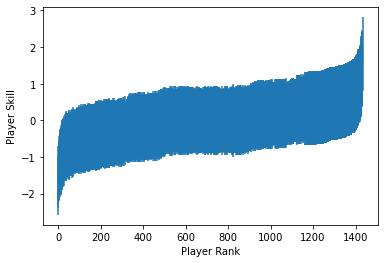

In [18]:

mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players),mean_skills[order], torch.exp(logstd_skills))

Simillary to part 1 we can plot samples from the joint posterior over the skills of some 2 players, for example let's take 'lelik3310' and 'thebestofthebad'. 

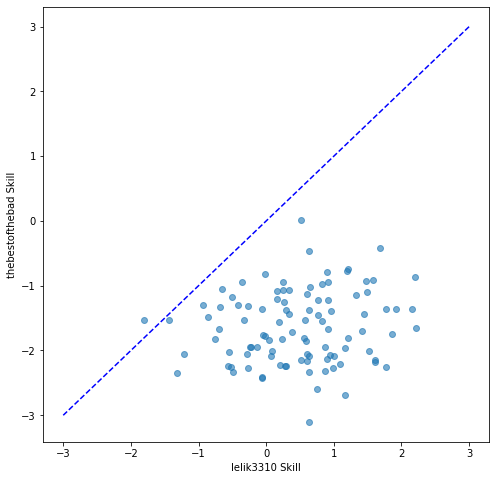

In [21]:
lelik3310_ix = np.where(names == "lelik3310")[0][0]
thebestofthebad_ix = np.where(names == "thebestofthebad")[0][0]

fig = plt.figure(figsize=(8,8), facecolor='white')

plt.xlabel("lelik3310 Skill")
plt.ylabel("thebestofthebad Skill")

plt.plot([3, -3], [3, -3], 'b--')

# Line of equal skill
samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

lelik3310 = samples[:, lelik3310_ix].detach()
thebestofthebad = samples[:, thebestofthebad_ix].detach()

plt.scatter(lelik3310, thebestofthebad, alpha=0.6)

As we can see based on the collected samples, the skills of lelik3310 appear to be better than the skills of thebestofthebad, since the samples are mainly located to the right of the diagonal.

Note that we can derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. 

At first let's apply a linear change of variables defining $y_A,y_B=z_A-z_B,z_B$, where $z_A$ and $z_B$ denote the independent skills of two players. Then we can conclude that $\mu_{y_A} = \mu_A - \mu_B$, where $\mu_A$ and $\mu_B$ are the means of skills $z_A$ and $z_B$. Then note that $P(z_A > z_B) = P(y_A> 0)$.

Since $y_A$ is a Gaussian random variable, we can use cumulative distribution function of Gaussian distribution ($\Phi$) to express $P(y_A> 0)$ as:

$$1 - P(y_A \leq0) = 1-\Phi \left(\frac{0-\mu_{y_A}}{\sigma_{y_A}} \right) $$
$$=1-\Phi \left(\frac{-(\mu_A-\mu_B)}{\sigma_{y_A}} \right)$$
$$= 1 - \Phi \left( \frac{\mu_B - \mu_A}{\sqrt{\sigma^2_A + \sigma^2_B}} \right)
$$


Using that derivation we will compute the probability that lelik3310 has higher skill than thebestofthebad. 

In [24]:
def prob_A_superior_B(N, A_ix, B_ix):
    mean_A,  sigma_A = mean_skills[A_ix], torch.exp(logstd_skills[A_ix])
    mean_B,  sigma_B = mean_skills[B_ix], torch.exp(logstd_skills[B_ix])

    formula_est = 1 - Normal(0,1).cdf((mean_B-mean_A) / torch.sqrt(sigma_A**2 + sigma_A**2))

    samples_A = Normal(mean_A, sigma_A).sample([N])
    samples_B = Normal(mean_B, sigma_B).sample([N])

    mc_est = (samples_A > samples_B).float().mean()
    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9760883450508118
Simple MC Estimate: 0.9887999892234802


## Comparing methods from Part 1 and 2

To answer the question of which approximate inference method is producing a better overall approximation to the true posterior over all skills conditioned on all games:

The SVI model's diagonal covariance matrix doesn't represent
relative skills between players very well. Even the trained approximations don't model
the true posterior distribution well. Recalling back to the HMC model, it's
apparent that it is more effective at approximating the true posterior. We can see that with MCMC the convergence took longer and skill rankings seemed to fluctuate more,but at the same time note that MCMC provides guarantee of generating samples from the true posterior distribution while variational inference does not provide this guarantee. Since the data set is not that big and we want to produce a better overall approximation to the true posterior over all skills MCMC would be a better algorithm.
